# Create hdf5 datasets from the geotiff images

In [1]:
import sys
import os
import numpy as np
import pylab as pl
from matplotlib.colors import ListedColormap
from importlib import reload
from skimage import exposure
import skimage
%matplotlib inline

# Internal modules
sys.path.insert(0, '../src')
import functions.geo_functions as geo_functions
import functions.filesystem as filesystem
import datasetGenerator.sampleGenerator as sampleGenerator
import datasetGenerator.mosaicGenerator as mosaicGen

reload(geo_functions)
reload(sampleGenerator)
reload(filesystem)
reload(mosaicGen)

/home/raian/anaconda3/envs/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


<module 'datasetGenerator.mosaicGenerator' from '../src/datasetGenerator/mosaicGenerator.py'>

In [2]:
DATA_DIR = os.path.join(os.path.abspath(os.path.dirname("__file__")), '../', 'data')
npzFile = os.path.join(DATA_DIR, 'generated', 'npy', 'PRODES2016_225-64_REP.npz')
rasterFile = os.path.join(DATA_DIR, "Landsat8_225-64_17-07-2016-R6G5B4.tif")

Shape labels:  (7741, 7591)
4 classes: |DESMATAMENTO| |FLORESTA| |HIDROGRAFIA| |NAO_FLORESTA| 


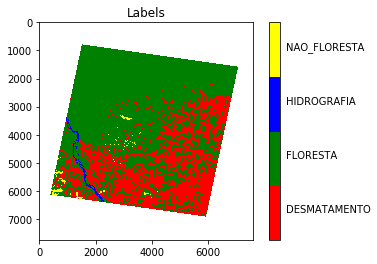

In [3]:
labels, id2label = geo_functions.load_labels(npzFile)
id2label = np.array([l for l in id2label])
nclasses = len(id2label)

print("Shape labels: ", labels.shape)

stringMsg = str(len(id2label)) + ' classes: '
for lab in id2label:
    stringMsg = stringMsg + "|" + str(lab, encoding="UTF-8") + "| "
print(stringMsg)

colorMap = ListedColormap(["red", "green", "blue", "yellow"])
pl.figure(figsize=(12, 5))
fig, ax = pl.subplots()
pl.title('Labels')
cax = ax.imshow(labels, cmap=colorMap)

cbar = fig.colorbar(cax)
cbar.ax.get_yaxis().set_ticks([])

for j, lab in enumerate(id2label):
    cbar.ax.text(1.5, (2 * j + 1) / 8, str(lab, encoding="UTF-8"), ha='left')

cbar.ax.get_yaxis().labelpad = 15
pl.savefig("../data/generated/ground_truth.png", dpi=200, bbox_inches='tight')

--- Loading Raster ---
   NUM Bands:  3
   Shape before roll:  (3, 7741, 7591)
   Shape after roll:  (7741, 7591, 3)


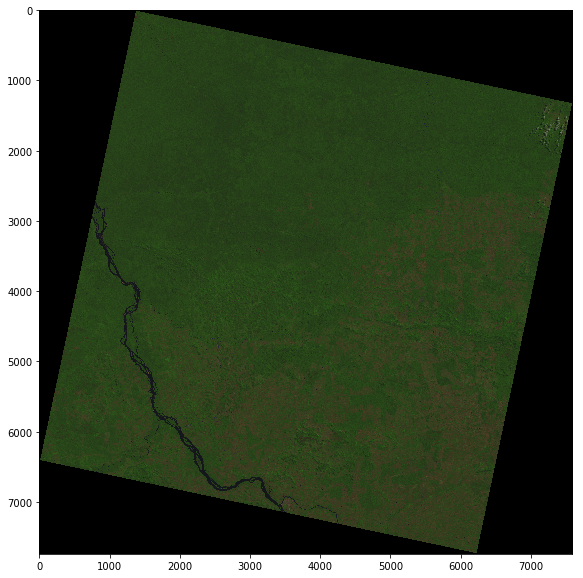

In [4]:
img_rgb = geo_functions.load_image(rasterFile)
img_rgb = skimage.img_as_float(img_rgb).astype(np.float32)
#img_rgb = exposure.equalize_hist(img_rgb)
pl.figure(figsize=(10, 10))
pl.imshow(img_rgb)

In [5]:
# @TODO(Raian): Review this cell
#rotationAngles=[0, 90, 180, 270]
#@TODO(Raian): Study this class and its methods.
#mosaic_builder = mosaicGen.RotatedImageMosaicBuilder(img_rgb, rotationAngles)
#mosaic = mosaic_builder.get_mosaic()

In [6]:
#pl.figure(figsize=(20,20))
#pl.title('RGB image')
#pl.imshow(mosaic)
#pl.axis('off')

In [19]:
reload(sampleGenerator)
rotationAngles = [0, 90, 180, 270]
window_size = 21
number_of_samples = 60000
# @TODO(Raian): Verify here how to take the samples from the mosaic.
# @TODO(Raian): Verify either how to take the labels.
# @TODO(Raian): Rotate the labels image together with the mosaic
sampleGen = sampleGenerator.SampleGenerator(img_rgb, labels, id2label)
sampleGen.computeSampleIndexes(number_of_samples)
sampleIndexes = sampleGen.getSampleIndexes()
print(sampleIndexes.shape)
sampleGen.extractWindows(window_size, True, os.path.join(DATA_DIR, "samples"))
samplesImg, samplesLabels = sampleGen.getSamples()
print("Number of Samples: ", len(samplesImg))
print("Sample Shape: ", samplesImg[0].shape)
sampleGen.saveSamplesToNPZ(os.path.join(DATA_DIR, 'generated', 'dataset_samples.npz'))
#colorMap = ListedColormap(["red", "green", "blue", "yellow"])
#sampleGen.saveSamplesToPNG(os.path.join(DATA_DIR, "samples"), colorMap)

(50, 2)
Number of Samples:  50
Sample Shape:  (21, 21, 3)


In [ ]:
pl.figure(figsize=(15,15))
count = 1
for x in range(1, 12):
    index = np.random.randint(len(samplesImg))
    subImg1 = samplesImg[index]
    subImg2 = samplesLabels[index]
    
    pl.subplot(5, 5, count)
    pl.axis('off')
    pl.imshow(subImg1, interpolation='nearest')
    count += 1
    
    colorMap = ListedColormap(["red", "green", "blue", "yellow"])
    pl.subplot(5, 5, count)
    pl.axis('off')
    pl.imshow(subImg2, interpolation='nearest', cmap=colorMap)
    count +=1
    
    #print(subImg2)

In [ ]:
# @TODO(Raian): Implement the data augmentation
#rotation_angles=[0, 90, 180, 270]

data = {
    "img" : img_rgb,
    "labels" : labels,
    "imgSamples" : samplesImg,
    "labeledSamples" : samplesLabels
}

filesystem.dict_to_hdf('../data/generated/dataset.hdf5', data)